<a href="https://colab.research.google.com/github/Gokulakrishnan200005/Predicting-energy-consumption-patterns-using-time-series-forcating-for-smart-grids-/blob/main/prediction%20energy%20consumption.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Importing Packages

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
from math import sqrt
from sklearn.preprocessing import MinMaxScaler

from keras.models import Sequential
from keras.layers import Dense, LSTM
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

Load the Dataset

In [ ]:
df = pd.read_csv("/content/ep.csv")


Print 5 rows

In [ ]:
df.head()

,Year_Factor,State_Factor,building_class,facility_type,floor_area,year_built,energy_star_rating,ELEVATION,january_min_temp,january_avg_temp,...,days_above_80F,days_above_90F,days_above_100F,days_above_110F,direction_max_wind_speed,direction_peak_wind_speed,max_wind_speed,days_with_fog,site_eui,id
0,1,State_1,Commercial,Grocery_store_or_food_market,61242,1942,11,2.4,36,50.5,...,14,0,0,0,1,1,1,NaN,248.6826155,0
1,1,State_1,Commercial,Warehouse_Distribution_or_Shipping_center,274000,1955,45,1.8,36,50.5,...,14,0,0,0,1,NaN,1,12,26.50014971,1
2,1,State_1,Commercial,Retail_Enclosed_mall,280025,1951,97,1.8,36,50.5,...,14,0,0,0,1,NaN,1,12,24.69361928,2
3,1,State_1,Commercial,Education_Other_classroom,55325,1980,46,1.8,36,50.5,...,14,0,0,0,1,NaN,1,12,48.40692567,3
4,1,State_1,Commercial,Warehouse_Nonrefrigerated,66000,1985,100,2.4,36,50.5,...,14,0,0,0,1,1,1,NaN,3.899395164,4


Before Preprocessing:Checking Null Values

In [ ]:
print("Missing values:\n")
df.isnull().sum()

Missing values:



,0
Year_Factor,0
State_Factor,0
building_class,0
facility_type,0
floor_area,0
...,...
direction_peak_wind_speed,4216
max_wind_speed,4175
days_with_fog,4252
site_eui,0


Replace  null values

In [ ]:
df.fillna(method='ffill', inplace=True)

<ipython-input-24-e9443599d05e>:1: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='ffill', inplace=True)


After Preprocessing

In [ ]:
df.head()

,Year_Factor,State_Factor,building_class,facility_type,floor_area,year_built,energy_star_rating,ELEVATION,january_min_temp,january_avg_temp,...,days_above_80F,days_above_90F,days_above_100F,days_above_110F,direction_max_wind_speed,direction_peak_wind_speed,max_wind_speed,days_with_fog,site_eui,id
0,1,State_1,Commercial,Grocery_store_or_food_market,61242,1942,11,2.4,36,50.5,...,14,0,0,0,1,1,1,NaN,248.6826155,0
1,1,State_1,Commercial,Warehouse_Distribution_or_Shipping_center,274000,1955,45,1.8,36,50.5,...,14,0,0,0,1,1,1,12,26.50014971,1
2,1,State_1,Commercial,Retail_Enclosed_mall,280025,1951,97,1.8,36,50.5,...,14,0,0,0,1,1,1,12,24.69361928,2
3,1,State_1,Commercial,Education_Other_classroom,55325,1980,46,1.8,36,50.5,...,14,0,0,0,1,1,1,12,48.40692567,3
4,1,State_1,Commercial,Warehouse_Nonrefrigerated,66000,1985,100,2.4,36,50.5,...,14,0,0,0,1,1,1,12,3.899395164,4


Before Outlier Checking

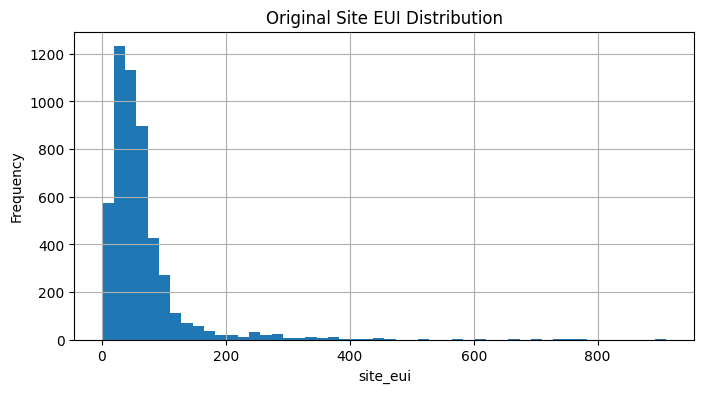

In [ ]:
df["site_eui"] = pd.to_numeric(df["site_eui"], errors="coerce")
# Plot original distribution
plt.figure(figsize=(8, 4))
df["site_eui"].hist(bins=50)
plt.title("Original Site EUI Distribution")
plt.xlabel("site_eui")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()

In [ ]:
Q1 = df["site_eui"].quantile(0.25)
Q3 = df["site_eui"].quantile(0.75)
IQR = Q3 - Q1

# Define bounds
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Count outliers
outliers = df[(df["site_eui"] < lower_bound) | (df["site_eui"] > upper_bound)]
print(f"Number of outliers in 'site_eui': {outliers.shape[0]}")



Number of outliers in 'site_eui': 332


After Outlier Checking

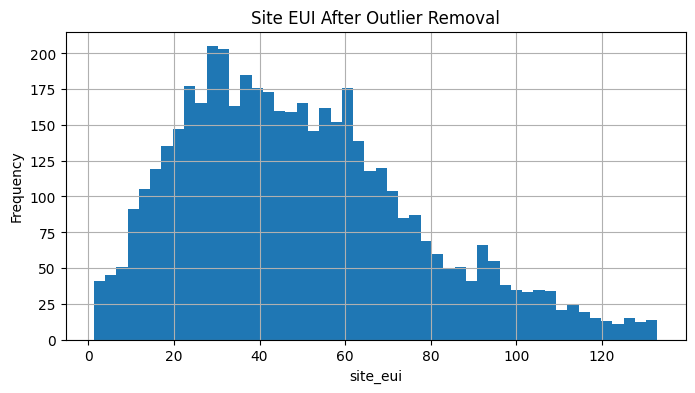

In [ ]:
df_filtered = df[(df["site_eui"] >= lower_bound) & (df["site_eui"] <= upper_bound)]

# Plot cleaned distribution
plt.figure(figsize=(8, 4))
df_filtered["site_eui"].hist(bins=50)
plt.title("Site EUI After Outlier Removal")
plt.xlabel("site_eui")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()


Convert columns into Numeric

In [ ]:
df['site_eui'] = pd.to_numeric(df['site_eui'], errors='coerce')
df['Year_Factor'] = pd.to_numeric(df['Year_Factor'], errors='coerce')

# Drop missing values in key fields
df = df.dropna(subset=['site_eui', 'Year_Factor'])

# Round year for grouping
df['year'] = df['Year_Factor'].round().astype('Int64')

In [ ]:
print("Basic statistics for Site Energy Use Intensity:")
print(df['site_eui'].describe())

Basic statistics for Site Energy Use Intensity:
count    4998.000000
mean       62.237728
std        62.249048
min         1.298082
25%        29.905965
50%        48.683151
75%        71.257383
max       910.563198
Name: site_eui, dtype: float64


Exploratory data Analysis(EDA)

1.Histogram

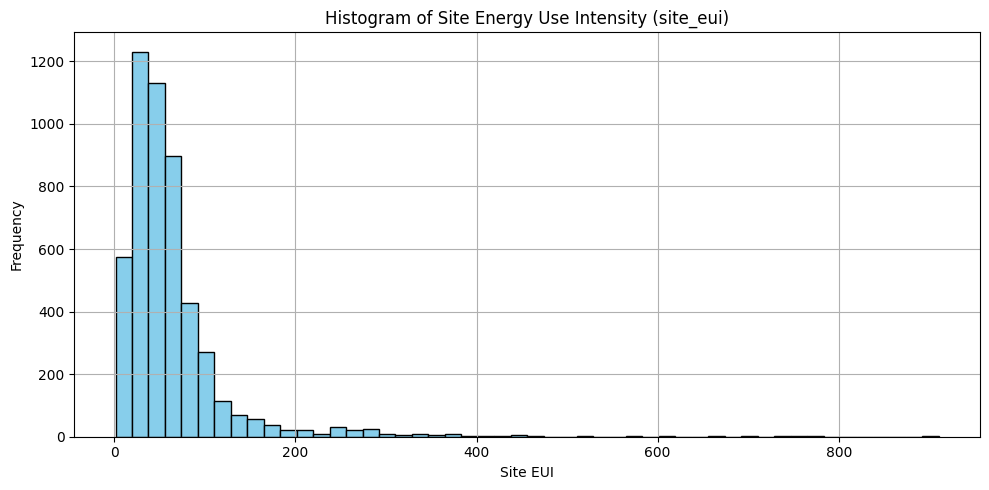

In [ ]:
plt.figure(figsize=(10, 5))
plt.hist(df["site_eui"], bins=50, color="skyblue", edgecolor="black")
plt.title("Histogram of Site Energy Use Intensity (site_eui)")
plt.xlabel("Site EUI")
plt.ylabel("Frequency")
plt.grid(True)
plt.tight_layout()
plt.show()


2.Heatmap

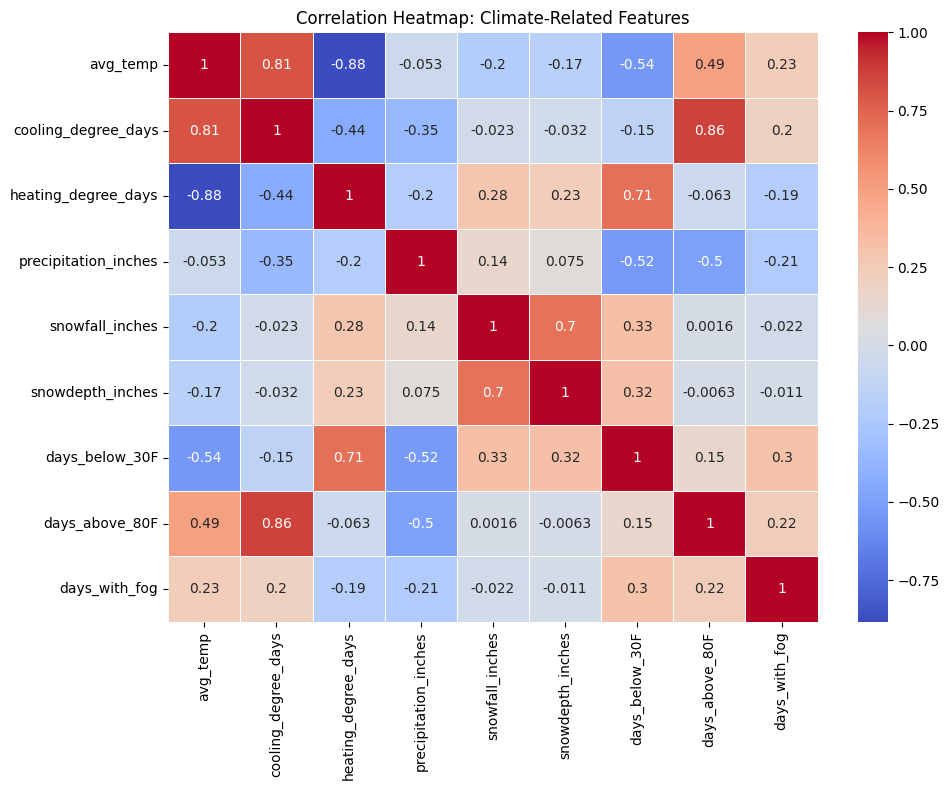

In [ ]:
climate_cols = [
    "avg_temp", "cooling_degree_days", "heating_degree_days",
    "precipitation_inches", "snowfall_inches", "snowdepth_inches",
    "days_below_30F", "days_above_80F", "days_with_fog"
]

# Convert columns to numeric
for col in climate_cols:
    if col in df.columns:
        df[col] = pd.to_numeric(df[col], errors="coerce")

# Drop rows with all missing climate values
df_climate = df[climate_cols].dropna(how="all")

# Compute correlation matrix
correlation_matrix = df_climate.corr()

# Plot heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", linewidths=0.5)
plt.title("Correlation Heatmap: Climate-Related Features")
plt.tight_layout()
plt.show()


3.Line plot

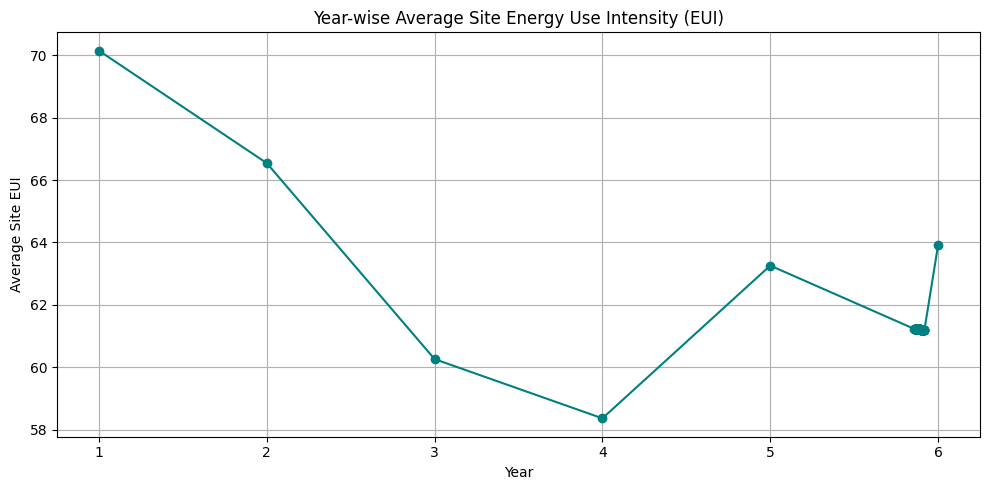

In [ ]:
df["Year_Factor"] = pd.to_numeric(df["Year_Factor"], errors="coerce")

# Drop missing values
df = df.dropna(subset=["site_eui", "Year_Factor"])

# Group by year and calculate mean site_eui
yearly_avg = df.groupby("Year_Factor")["site_eui"].mean().reset_index()

# Plot
plt.figure(figsize=(10, 5))
plt.plot(yearly_avg["Year_Factor"], yearly_avg["site_eui"], marker="o", linestyle="-", color="teal")
plt.title("Year-wise Average Site Energy Use Intensity (EUI)")
plt.xlabel("Year")
plt.ylabel("Average Site EUI")
plt.grid(True)
plt.tight_layout()
plt.show()


Visualizations

1.Bar Chart

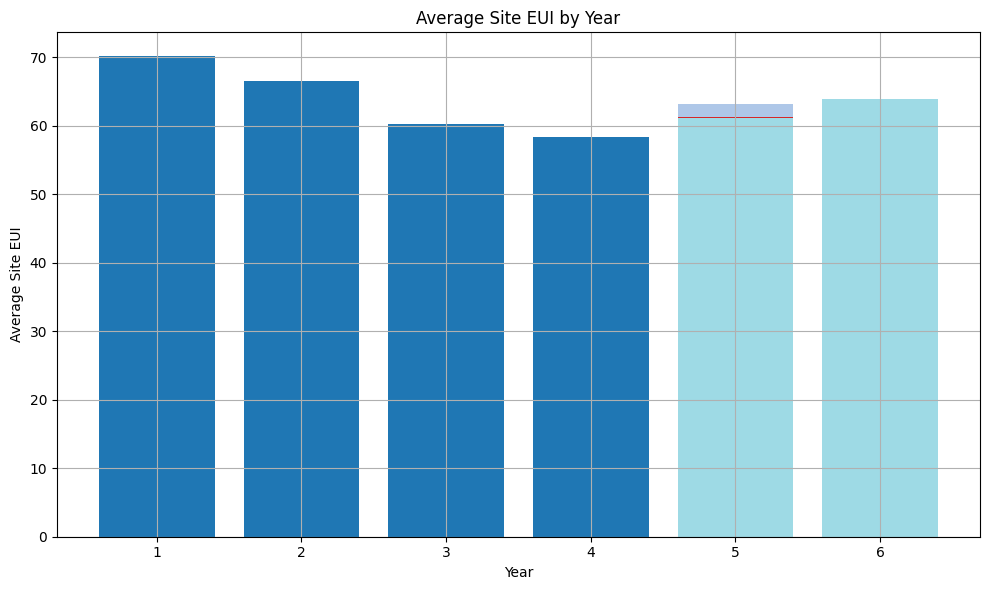

In [ ]:
df_bar = df.groupby("Year_Factor")["site_eui"].mean().reset_index()
df_bar["Year_Factor"] = df_bar["Year_Factor"].astype(int)

# Generate colors using a colormap (e.g., viridis or tab20)
colors = plt.cm.tab20(np.linspace(0, 1, len(df_bar)))

# Plot with multiple colors
plt.figure(figsize=(10, 6))
plt.bar(df_bar["Year_Factor"], df_bar["site_eui"], color=colors)
plt.title("Average Site EUI by Year")
plt.xlabel("Year")
plt.ylabel("Average Site EUI")
plt.grid(True)
plt.tight_layout()
plt.show()

2.Pie Chart

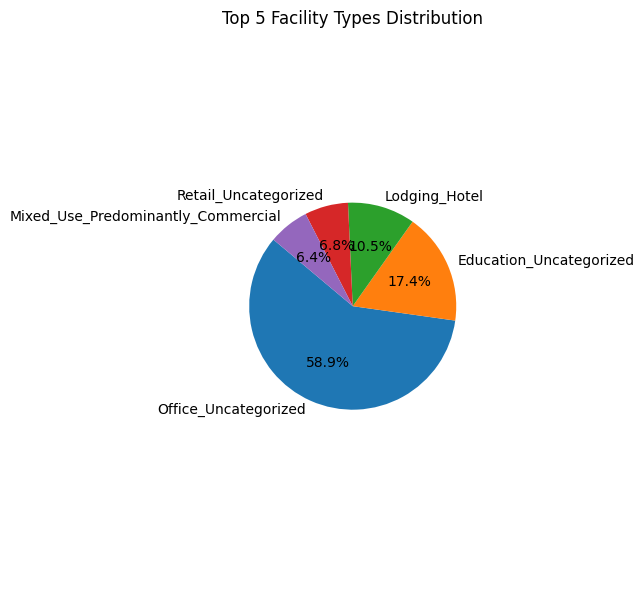

In [ ]:
top_facilities = df["facility_type"].value_counts().nlargest(5)
plt.figure(figsize=(6, 6))
plt.pie(top_facilities.values, labels=top_facilities.index, autopct='%1.1f%%', startangle=140)
plt.title("Top 5 Facility Types Distribution")
plt.axis("equal")
plt.tight_layout()
plt.show()

**3.Box plot**

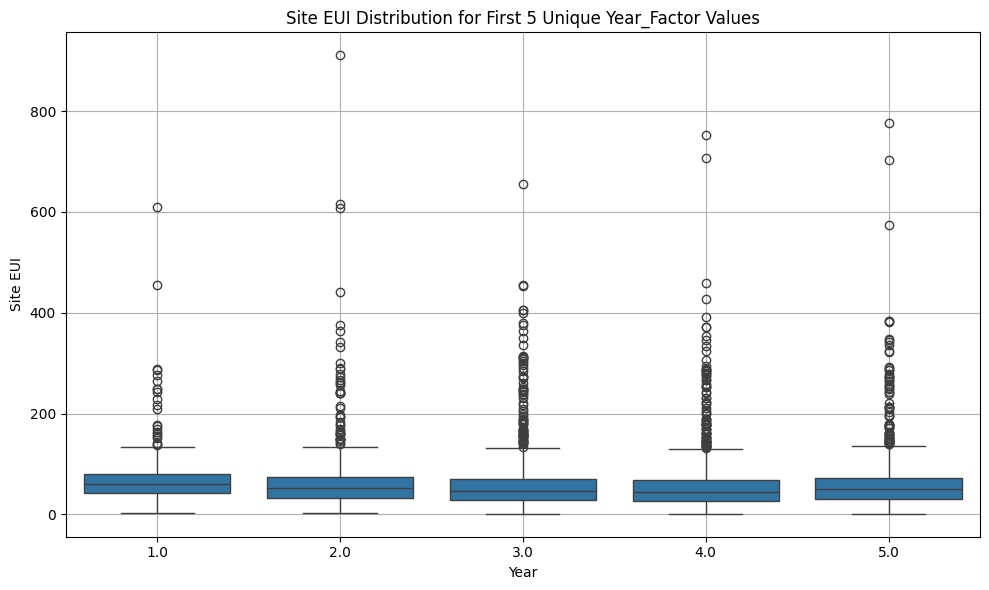

In [ ]:
unique_years = df["Year_Factor"].dropna().unique()[:5]
df_subset = df[df["Year_Factor"].isin(unique_years)]

# Create the boxplot
plt.figure(figsize=(10, 6))
sns.boxplot(x="Year_Factor", y="site_eui", data=df_subset)
plt.title("Site EUI Distribution for First 5 Unique Year_Factor Values")
plt.xlabel("Year")
plt.ylabel("Site EUI")
plt.grid(True)
plt.tight_layout()
plt.show()

**4.Scatter Plot**

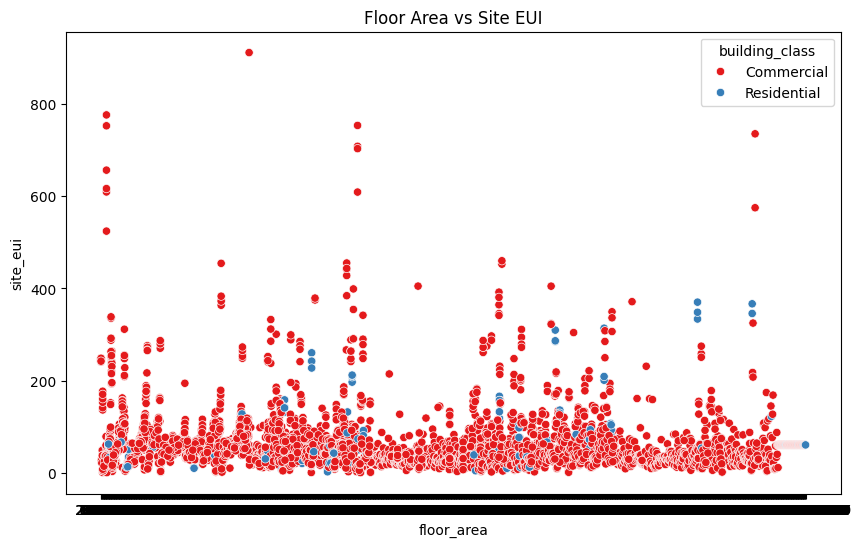

In [ ]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x='floor_area', y='site_eui', data=df, hue='building_class', palette='Set1')
plt.title('Floor Area vs Site EUI')
plt.show()

5.Violin plot

<ipython-input-17-1d7d2affcbcc>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x='facility_type', y='site_eui', data=df, palette='muted')


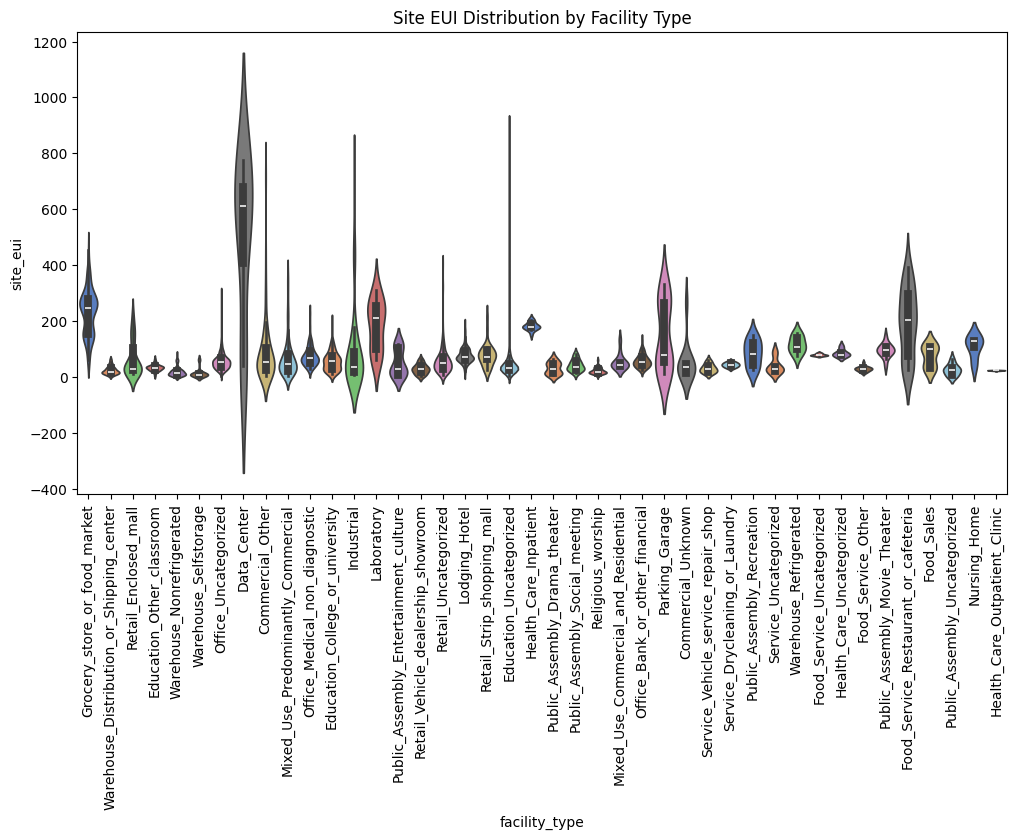

In [ ]:
plt.figure(figsize=(12, 6))
sns.violinplot(x='facility_type', y='site_eui', data=df, palette='muted')
plt.title('Site EUI Distribution by Facility Type')
plt.xticks(rotation=90)
plt.show()